In [1]:
import numpy as np
### fix old numpy code in LVISEval (np.float is deprecated)
if not hasattr(np, "float"):
    np.float = float
import torch
import torchvision
import requests
import sys
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from constants import *
from typing import List, Tuple, Literal

In [2]:
### add this if on colab:
# !pip install lvis 
### remove if on colab:
from constants import * 
import lvis

## Dataset

In [3]:
from torch.utils.data import Dataset
from torchvision.io import decode_image
from torchvision import tv_tensors
from torchvision.ops import box_convert
from PIL import Image
from io import BytesIO

### with help of https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html


class LVISDataset(Dataset):
    def __init__(self, img_dirs: List[str], lvis_gt: lvis.LVIS, transforms=None, cat_ids=None) -> None:
        self.img_dirs = img_dirs
        self.lvis_gt = lvis_gt
        self.transforms = transforms
        self._create_index(cat_ids) 

    def _create_index(self, cat_ids):
        self.img_ids = self.lvis_gt.get_img_ids() if cat_ids is None else self._get_img_ids(cat_ids)
        self.cat_ids = self.lvis_gt.get_cat_ids() if cat_ids is None else cat_ids
        self.cat_id_to_label = {cat_id: i+1 for i, cat_id in enumerate(self.cat_ids)}
        self.label_to_cat_id = {i+1: cat_id for i, cat_id in enumerate(self.cat_ids)}
        if  all(isinstance(dir, str) for dir in self.img_dirs) and all(os.path.isdir(dir) for dir in self.img_dirs):
            self._get_image = self._get_image_from_file
            print("will load images from files")
        else:
            self._get_image = self._get_image_from_url
            print("will load images from urls")

    def _get_img_ids(self, cat_ids):
        return list({
            iid for cat_id in cat_ids
            for iid in self.lvis_gt.cat_img_map[cat_id]
        })
    
    def _get_image_from_file(self, id):
        image_paths = [os.path.join(images_dir, f'{str(id).zfill(12)}.jpg') for images_dir in self.img_dirs]
        for image_path in image_paths:
            if os.path.isfile(image_path):
                return decode_image(image_path)
        print(f"image not found: {image_paths}")
        sys.exit(1)

    def _get_image_from_url(self, id):
        url = self.lvis_gt.imgs[id]['coco_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        return img
    
    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx: int):
        ### get image
        img_id = self.img_ids[idx]
        img = self._get_image(img_id)
        img = tv_tensors.Image(img)
        _, h, w = img.shape

        ### get annotationss
        annot_ids = self.lvis_gt.get_ann_ids(img_ids=[img_id])
        annots = self.lvis_gt.load_anns(annot_ids)
        annots = [annot for annot in annots if annot['category_id'] in self.cat_ids]
        # labels
        labels = torch.tensor([self.cat_id_to_label[annot['category_id']] for annot in annots])
        # area
        areas = torch.tensor([annot['area'] for annot in annots])
        # boxes
        boxes = torch.tensor([annot['bbox'] for annot in annots], dtype=torch.float32)
        boxes_xyxy = box_convert(boxes, in_fmt='xywh', out_fmt='xyxy')
        boxe_tv = tv_tensors.BoundingBoxes(boxes_xyxy, format= 'XYXY', canvas_size=(h,w)) # type: ignore
        # masks
        masks = [torch.from_numpy(self.lvis_gt.ann_to_mask(ann)) for ann in annots] # shape: (N, H, W)
        mask_tv = tv_tensors.Mask(torch.stack(masks))

        target = {}
        target['image_id'] = img_id
        target['labels'] = labels
        target['area'] = areas
        target['boxes'] = boxe_tv
        target['masks'] = mask_tv

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

## Model

In [4]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


### with help of https://docs.pytorch.org/tutorials/intermediate/torchvision_tutorial.html


def get_model_instance_segmentation(num_classes):
    # load pretrained maskrcnn
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features # type: ignore
    # replace the pre-trained head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # get number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # type: ignore
    hidden_layer = 256
    # replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor( in_features_mask, hidden_layer, num_classes)
    return model


class MaskRCNNWrapper(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = get_model_instance_segmentation(num_classes)

    def forward(self, images, targets=None):
        return self.model(images, targets)
    
    def freeze(self):
        """
        Freezes backbone layer learning.
        To prevent unlearning learned features.
        """
        for param in self.model.backbone.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        """
        Unfreezes backbone layer learning.
        """
        for param in self.model.backbone.parameters():
            param.requires_grad = True


## Utils

#### Data

In [5]:
from torchvision.transforms import v2 as T
from typing import Tuple


def get_transform(img_size: Tuple[int, int] | None = None, training=True):
    transforms = []
    if img_size is not None:
        transforms.append(T.Resize(img_size))
    if training:
        transforms.append(T.RandomHorizontalFlip())
    transforms.append(T.ToDtype(torch.float32, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)


def custom_collate_fn(batch):
    """
    Custom collate function to prevent stacking of images with different shapes
    """
    return tuple(zip(*batch))


def get_filtered_cat_ids(cats, names):
    """
    Get a list of ids of given list of categories
    """
    cat_ids = []
    cat_names = []
    for id, cat in cats.items():
        if cat['name'] in names:
            cat_ids.append(id)
            cat_names.append(cat['name'])
    print(f'category found for {[name for name in names if name in cat_names]}')
    print(f'category NOT found for {[name for name in names if name not in cat_names]}\n')
    return cat_ids

#### Train

In [ ]:
import math


def train_one_epoch(model, optimizer, data_loader, epoch, device, scaler=None, print_freq:None|int =10):
    model.train()
    total_batches = len(data_loader)
    lr_scheduler = None
    if epoch==0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    total_loss = 0
    for i, (images, targets) in enumerate(tqdm(data_loader, desc="TRAIN EPOCH (/batches)")):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.amp.autocast(device_type=device.type, enabled= scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item() # type: ignore
        total_loss += loss_value
        if lr_scheduler is not None:
            lr_scheduler.step()
        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward() # type: ignore
            optimizer.step()

        if print_freq is not None and i % print_freq == 0:
            tqdm.write(f"[batch {i+1}/{total_batches}] loss: {loss_value}")
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training \nLoss dict:\n{loss_dict}")
            sys.exit(1)
        
    return total_loss / total_batches


@torch.no_grad()
def evaluate(model, data_loader, device):
    model.train()
    total_loss = 0
    #ious = []
    #dices = []
    for images, targets in tqdm(data_loader, desc="VALIDATION (/batches)"):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        # get loss
        loss_dict = model(images, targets)
        total_loss += sum(loss.item() for loss in loss_dict.values())
        """# get preds for ious and dices
        preds = model(images)
        for p, t in zip(preds, targets):
            ious.append(compute_iou(p,t))
            dices.append(compute_dice(p,t))"""

    val_loss = total_loss / len(data_loader)
    """mean_iou = sum(ious) / len(ious)
    mean_dice = sum(dices) / len(dices)"""
    return val_loss #, mean_dice, mean_iou


def train(
    model, optimizer, lr_scheduler, 
    train_loader, val_loader, 
    epochs, patience,
    device, scaler =None,
    print_freq:None|int =10
):
    train_losses = []
    val_losses = []
    best_model_epoch = 0
    best_loss = float('inf')
    epochs_no_improvement = 0

    for epoch in tqdm(range(epochs), desc= 'TRAINING LOOP (/epochs)'):
        loss_train = train_one_epoch(model, optimizer, train_loader, epoch, device, scaler, print_freq)
        train_losses.append(loss_train)

        loss_val = evaluate(model, val_loader, device)
        val_losses.append(loss_val)

        tqdm.write(f"[epoch {epoch+1}/{epochs}]: train loss = {loss_train} | val loss = {loss_val}")
        if loss_val < best_loss:
            best_loss = loss_val
            best_model_epoch = epoch
            epochs_no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improvement += 1
            tqdm.write(f"NO improvement [{epochs_no_improvement}/{patience}]")
            if epochs_no_improvement >= patience:
                print("Patience reached, stopping training")
                break
        lr_scheduler.step()
    return train_losses, val_losses, best_model_epoch

#### Evaluation

In [7]:
from lvis import LVISResults, LVISEval
import pycocotools.mask as maskUtils


# TODO masks do not seem to be in the right format
@torch.inference_mode()
def get_predictions(model, data_loader, device, score_thresh=0.5):
    model.eval()
    predictions = []
    for images, targets in tqdm(data_loader, desc="BATCHES"):
        images = list(image.to(device) for image in images)
        outputs = model(images)
        for o, t in zip(outputs, targets):
            image_id = t["image_id"]
            boxes = o["boxes"].cpu().numpy()
            scores = o["scores"].cpu().numpy()
            labels = o["labels"].cpu().numpy()
            masks = o["masks"].cpu().numpy()[:, 0, :, :]
            for box, score, label, mask in zip(boxes, scores, labels, masks):
                if score_thresh is not None and score < score_thresh:
                    continue
                mask_bin = (mask > 0.5).astype(np.uint8)
                rle = maskUtils.encode(np.asfortranarray(mask_bin))
                rle['counts'] = rle['counts'].decode('utf-8')
                x1, y1, x2, y2 = box
                predictions.append({
                    "image_id": image_id,
                    "category_id": data_loader.dataset.dataset.label_to_cat_id[int(label)], # dict inside dataset in subset in loader
                    "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    "segmentation":rle,
                    "score": float(score)
                })
    return predictions


@torch.inference_mode()
def run_lvis_eval(model, data_loader, lvis_gt, cat_ids, device, iou_type:Literal["bbox","segm"]="segm", score_thresh=0.5):
    predictions = get_predictions(model, data_loader, device, score_thresh)
    if len(predictions) == 0:
        print("No detections — skipping LVIS evaluation.")
    else:
        lvis_dt = LVISResults(lvis_gt, predictions)
        lvis_eval = LVISEval(lvis_gt, lvis_dt, iou_type)
        lvis_eval.params.cat_ids = cat_ids
        lvis_eval.run()
        lvis_eval.print_results()

#### Plot

In [8]:
def add_img_and_mask(ax, mask, name, color):
    ys, xs = np.nonzero(mask)
    y, x = ys.mean(), xs.mean()
    overlay = np.zeros((*mask.shape, 4))
    overlay[...,:3] = color[:3] # apply colors except alphas
    overlay[...,3] = mask * 0.5 # alpha is the 0.5 where mask exists
    ax.imshow(overlay)
    ax.text(x, y, name, color="white", ha="center", va="center")


def plot_images_with_anns(img, target, pred, label_to_name=None, pred_thresh=0.5):
    img_np = img.permute(1,2,0).cpu().numpy()
    pmasks = pred['masks'].cpu().numpy()[:, 0, :, :]
    pmasks = (pmasks > pred_thresh).astype(np.uint8) # to binary mask
    plabels = pred['labels'].cpu().numpy()
    tmasks = target['masks'].cpu().numpy()
    tlabels = target['labels'].cpu().numpy()

    _, axes = plt.subplots(1, 2, figsize=(8, 8))
    ax_l, ax_r = axes
    ax_l.imshow(img_np.astype(np.float32))
    ax_r.imshow(img_np.astype(np.float32))
    for tlabel, tmask in zip(tlabels, tmasks):
        if not np.any(tmask):
            continue    # skip empty mask
        label_name = label_to_name[tlabel] if label_to_name is not None and tlabel in label_to_name else str(tlabel)
        color = plt.get_cmap("tab20")(tlabel % 20)
        add_img_and_mask(ax_l, tmask, label_name, color)
    for plabel, pmask in zip(plabels, pmasks):
        if not np.any(pmask):
            continue    # skip empty mask
        label_name = label_to_name[plabel] if label_to_name is not None and plabel in label_to_name else str(plabel)
        color = plt.get_cmap("tab20")(plabel % 20)
        add_img_and_mask(ax_r, pmask, label_name, color)
    ax_l.set_axis_off()
    ax_r.set_axis_off()
    plt.tight_layout()
    plt.show()


def plot_losses(train_losses, val_losses, early_stop = None, filepath=None):
    _, ax = plt.subplots(figsize=((12, 6)))
    epochs = np.arange(1,len(train_losses)+1,1)
    ax.plot(epochs, train_losses, 'r', label='Training Loss')
    ax.plot(epochs, val_losses, 'g', label='Validation Loss')
    if early_stop is not None:
        plt.scatter(epochs[early_stop], val_losses[early_stop], marker='x', c='g', label='Saved Model Epoch')
    ax.set_title('Loss Plots')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc="upper right")
    plt.show()
    if filepath is not None: 
        plt.savefig(filepath)

## Pipeline

#### Arguments

In [9]:
### Device
NO_AMP:bool = False
PIN_MEMORY:bool = True
NUM_WORKERS:int = 0 # int (0: main process)

### Data
MAX_IMAGES:int = 20     # 80/20 split (train: 0.8*max_img | val: 0.2*max_img)
CATEGORIES:List[str] = ['cat', 'dog']  #, 'cow', 'pigeon', 'giraffe', 'bear']
IMG_SIZE:Tuple[int]|None = None #(256, 256)  # if None: no resize

### Learning
LR:float = 1e-3
MOMENTUM:float = 0.9
EPOCHS:int = 3
BATCH_SIZE:int = 3
PATIENCE:int = 5

### Others
BATCH_PRINT_FREQ:int|None = None # None: no print inside epoch
SAVE_MODEL_PATH:str = 'best_model.pt'

#### Data Preparation

In [10]:
### load annotations
from lvis import LVIS
lvis_gt_train = LVIS(TRAIN_ANNOT_PATH)
lvis_gt_val = LVIS(VAL_ANNOT_PATH)

In [11]:
### create datasets/dataloaders
from torch.utils.data import DataLoader, Subset

cat_ids = get_filtered_cat_ids(lvis_gt_train.cats, CATEGORIES)
num_classes = len(cat_ids) + 1  # +1 for background

# train
dataset_train = LVISDataset([COCO2017_TRAIN_PATH], lvis_gt_train, get_transform(IMG_SIZE, training=True), cat_ids)
subset_train = Subset(dataset_train, (torch.randperm(len(dataset_train))[:int(MAX_IMAGES*0.8)]).tolist())
train_loader = DataLoader(subset_train, 
                          batch_size=BATCH_SIZE, 
                          collate_fn=custom_collate_fn, 
                          shuffle=True, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=PIN_MEMORY)
print(f"Size of train dataset: {len(dataset_train)}")
print(f"Size of train subset: {len(subset_train)}\n")

# val
dataset_val = LVISDataset([COCO2017_VAL_PATH, COCO2017_TRAIN_PATH], lvis_gt_val, get_transform(IMG_SIZE, training=False), cat_ids)
subset_val = Subset(dataset_val, (torch.randperm(len(dataset_val))[:int(MAX_IMAGES*0.2)]).tolist())
val_loader = DataLoader(subset_val, 
                        batch_size=BATCH_SIZE, 
                        collate_fn=custom_collate_fn, 
                        num_workers=NUM_WORKERS, 
                        pin_memory=PIN_MEMORY)
print(f"Size of validation dataset: {len(dataset_val)}")
print(f"Size of validation subset: {len(subset_val)}")

# for faster evaluation (when instancing LVISResults):
lvis_gt_val.cats= {k: v for k, v in lvis_gt_val.cats.items() if k in cat_ids}
lvis_gt_train.cats= {k: v for k, v in lvis_gt_train.cats.items() if k in cat_ids}

category found for ['cat', 'dog']
category NOT found for []

will load images from urls
Size of train dataset: 3819
Size of train subset: 16

will load images from urls
Size of validation dataset: 745
Size of validation subset: 4


#### Training

In [12]:
### Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = torch.amp.GradScaler('cuda') if device.type == 'cuda' and not NO_AMP else None

model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=0.8
)

TRAINING LOOP (/epochs):   0%|          | 0/3 [00:00<?, ?it/s]

TRAIN EPOCH (/batches):   0%|          | 0/6 [00:00<?, ?it/s]

c:\Users\bogae\Desktop\imageProcessing\projet\ProjetAIIP\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


VALIDATION (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

[epoch 1/3]: train loss = 3.5825605392456055 | val loss = 1.1695592794276308


TRAIN EPOCH (/batches):   0%|          | 0/6 [00:00<?, ?it/s]

VALIDATION (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

[epoch 2/3]: train loss = 1.1608019769191742 | val loss = 0.7942368379517575


TRAIN EPOCH (/batches):   0%|          | 0/6 [00:00<?, ?it/s]

VALIDATION (/batches):   0%|          | 0/2 [00:00<?, ?it/s]

[epoch 3/3]: train loss = 0.8866195182005564 | val loss = 0.6398121552847442


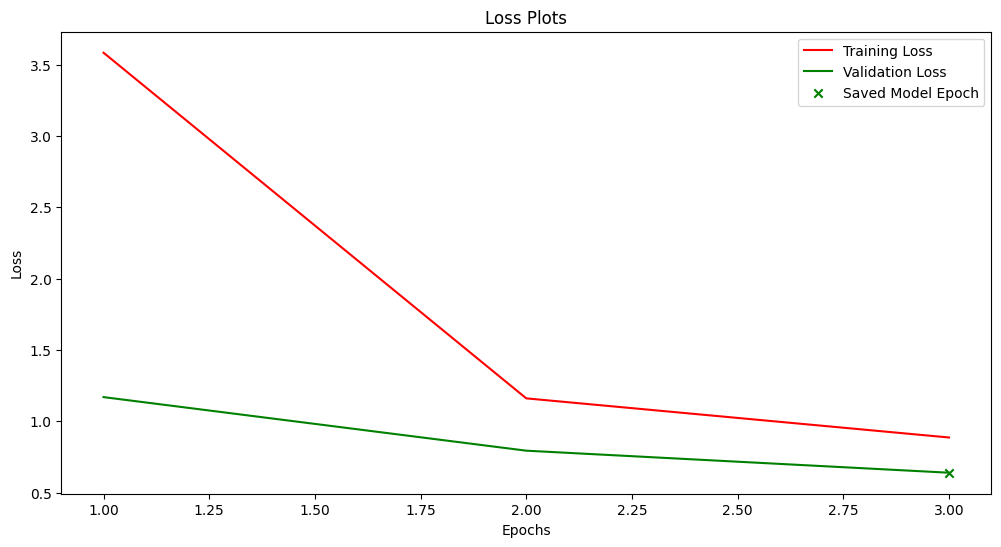

<Figure size 640x480 with 0 Axes>

In [13]:
### Training Loop
train_losses, val_losses, best_epoch = train(model, 
                                             optimizer, lr_scheduler, 
                                             train_loader, val_loader,
                                             EPOCHS, PATIENCE, 
                                             device, scaler, BATCH_PRINT_FREQ)
plot_losses(train_losses, val_losses, early_stop = best_epoch, filepath="losses.jpg")

#### Evaluation & Visualisation

In [18]:
### load best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
best_model = get_model_instance_segmentation(num_classes)
best_model.load_state_dict(torch.load(SAVE_MODEL_PATH, map_location=device))
best_model.to(device)
print('')

cpu



In [15]:
### run full LVIS evaluation
run_lvis_eval(best_model, val_loader, lvis_gt_val, cat_ids, device, iou_type="segm")

BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\bogae\Desktop\imageProcessing\projet\ProjetAIIP\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


No detections — skipping LVIS evaluation.


c:\Users\bogae\Desktop\imageProcessing\projet\ProjetAIIP\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


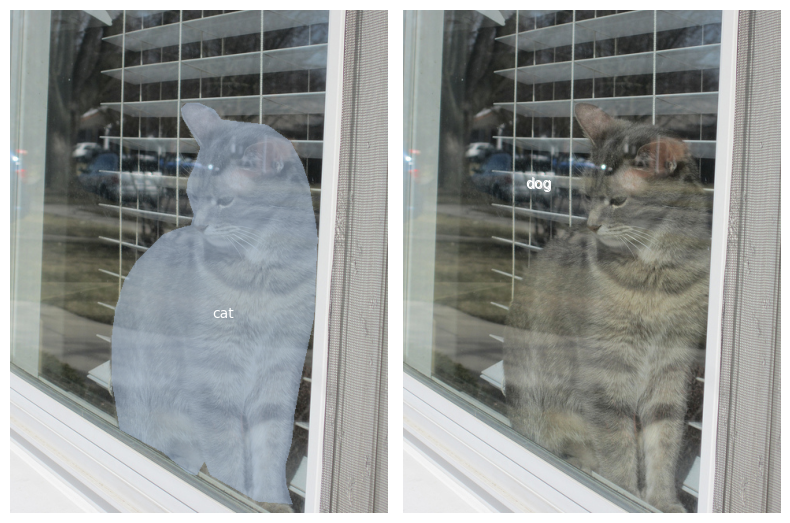

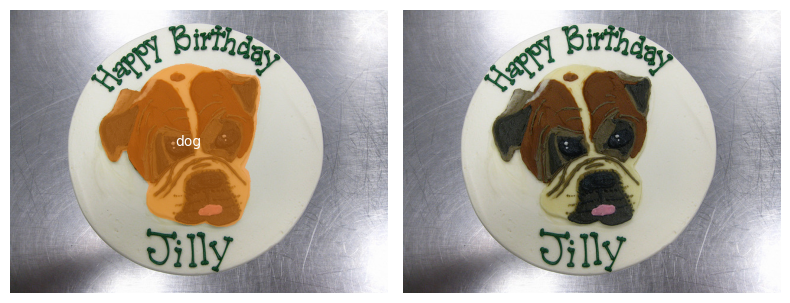

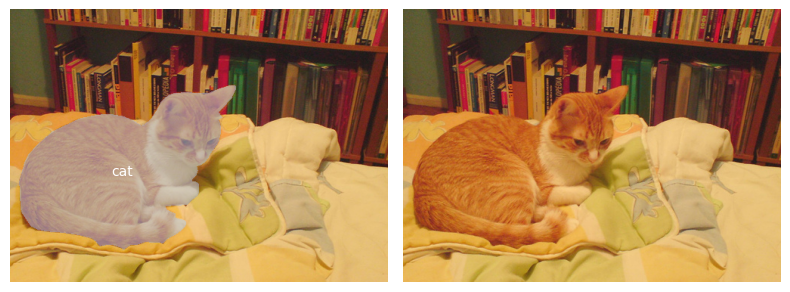

In [19]:
### visualization
IMAGES_TO_SHOW = 5
PRED_THRESH = 0.8

label_to_name = {k: lvis_gt_val.load_cats([v])[0]['name'] for k, v in val_loader.dataset.dataset.label_to_cat_id.items()}

images, targets = next(iter(val_loader))
images = [img.to(device) for img in images]
best_model.eval()
with torch.no_grad():
    preds = best_model(images)
for i in range(min(IMAGES_TO_SHOW, len(images))):
    plot_images_with_anns(images[i], targets[i], preds[i], label_to_name, PRED_THRESH)

# --- tests ---

In [17]:
from lvis import LVISVis

predictions = get_predictions(model, val_loader, device)
if len(predictions) == 0:
    print("No detections — skipping LVIS evaluation.")
else:
    lvis_dt = LVISResults(lvis_gt_val, predictions)

lvis_vis = LVISVis(lvis_gt_val, lvis_dt, img_dir=COCO2017_VAL_PATH)

BATCHES:   0%|          | 0/2 [00:00<?, ?it/s]

No detections — skipping LVIS evaluation.


NameError: name 'lvis_dt' is not defined

In [ ]:
from lvis import LVIS, LVISVis

lvis_gt = LVIS(VAL_ANNOT_PATH)

lvis_vis = LVISVis(lvis_gt, img_dir=COCO2017_VAL_PATH)

lvis_vis.vis_img(285)

In [ ]:
# model training output
model = get_model_instance_segmentation(num_classes)
print("debug 1")
images, targets = next(iter(train_loader))
print("debug 2")
images = list(image for image in images)
print("debug 3")
targets = [{k: v for k, v in t.items()} for t in targets]
print("debug 4")
output = model(images, targets)  # Returns losses and detections
print("debug 5")
print(output)

In [ ]:
# model inference output
@torch.inference_mode()
def test(model) :
    model.eval()
    print("debug 1")
    x = [torch.rand(3, 300, 400).to(device), torch.rand(3, 500, 400).to(device)]
    print("debug 2")
    predictions = model(x)  # Returns predictions
    print("debug 3")
    print(predictions[0])

test(model)

In [ ]:
import cv2

img = cv2.imread("../coco2017/train2017/000000055296.jpg")
if img is None : 
    print("erreur imgage pas found")
cv2.imshow("test", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import json

with open("data/lvis_v1_val.json", "r") as f:
    data = json.load(f)


category_fields = list(data["categories"][0].keys())

print(category_fields)
